# Análise de Acidentes nas Rodovias Federais do Brasil (2007-2025)

**Integrantes:**
* José Alexandre Bezerra de Oliveira
* Josinaldo da Silva Sousa
* Luiz Henrique Santos da Graça

---

### **Introdução**

#### **Motivação**

Os acidentes de trânsito representam um grave problema de saúde pública e um desafio socioeconômico no Brasil. Anualmente, milhares de vidas são perdidas e muitas outras são impactadas por lesões, gerando um custo elevado para a sociedade, tanto em termos humanos quanto financeiros. As rodovias federais, por serem os principais eixos de transporte de pessoas e cargas do país, concentram uma parcela significativa dessas ocorrências.

Entender a dinâmica por trás desses acidentes é fundamental para o desenvolvimento de políticas públicas mais eficazes, campanhas de conscientização direcionadas e estratégias de fiscalização mais eficientes. Através da análise de dados históricos, é possível identificar padrões, compreender o impacto de intervenções passadas e, consequentemente, encontrar caminhos para tornar nossas estradas mais seguras.

#### **Objetivos**

Este trabalho tem como objetivo principal realizar uma análise exploratória detalhada sobre a série histórica de acidentes registrados pela Polícia Rodoviária Federal (PRF) entre os anos de 2007 e 2025. Buscamos extrair insights valiosos que possam responder às seguintes questões centrais:

1.  **Qual foi a evolução do número de acidentes** nas rodovias federais brasileiras e quais fatores externos podem ter influenciado essa tendência?
2.  A **severidade dos acidentes**, medida pelo número de mortes, seguiu a mesma tendência de queda? É possível modelar essa redução ao longo do tempo?
3.  Quais são os **padrões de risco de acidentes fatais** considerando os dias da semana e os diferentes períodos do dia?
4.  Quais as **principais causas e tipos de acidentes** e como eles se relacionam com a letalidade dos eventos?
5.  Com base na média de mortes, é possível **agrupar as horas do dia** em diferentes perfis de risco?
6.  Qual perfil das vitimas que mais estão propensas a sofrerem acidentes em JP ?

Ao final, esperamos consolidar uma visão clara sobre os principais fatores de risco e as tendências temporais, fornecendo uma base analítica sólida para futuras investigações e possíveis tomadas de decisão na área de segurança viária.



### **Dados Usados**

Os dados utilizados nesta análise foram coletados do portal de Dados Abertos da Polícia Rodoviária Federal (PRF). O conjunto de dados consolida as ocorrências de acidentes nas rodovias federais de todo o Brasil durante o período de 1 de janeiro de 2007 a meados de 2025.

O dataset final contém aproximadamente 1.5 milhão de registros, onde cada registro corresponde a um acidente único. Ele é composto por 26 colunas que detalham informações sobre a data, localização, tipo, causa, condições climáticas e o balanço de vítimas de cada acidente.

# Link para o Dicionário do DATASET
https://drive.google.com/file/d/11zOQvccvoVSImByIp5-E0PxJ2larrEXy/view

---

# Importações e Bibliotecas Necessárias:

In [5]:
import pandas as pd
import glob
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


# Tratamento da Tabela:

In [2]:
url = "https://drive.google.com/uc?id=16KX1AtqOx06VWOOflwnLn9KL90EEueZ1"
output = "datatran2007_2025.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=16KX1AtqOx06VWOOflwnLn9KL90EEueZ1
From (redirected): https://drive.google.com/uc?id=16KX1AtqOx06VWOOflwnLn9KL90EEueZ1&confirm=t&uuid=30eb370a-dd83-44e6-8dd8-7ea57a01b878
To: c:\Users\henri\Desktop\Meus Projetos\Trabalho-ICD\Trabalho-ICD-2025.1\datatran2007_2025.csv
100%|██████████| 214M/214M [00:05<00:00, 39.8MB/s] 


'datatran2007_2025.csv'

In [3]:
tabela2007_2025 = pd.read_csv('datatran2007_2025.csv')

In [4]:
# Limpeza de Dados Vazios
tabela2007_2025 = tabela2007_2025.dropna()

print(tabela2007_2025.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504783 entries, 0 to 1504782
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   data_inversa            1504783 non-null  object
 1   dia_semana              1504783 non-null  object
 2   horario                 1504783 non-null  object
 3   uf                      1504783 non-null  object
 4   municipio               1504783 non-null  object
 5   causa_acidente          1504783 non-null  object
 6   tipo_acidente           1504783 non-null  object
 7   classificacao_acidente  1504783 non-null  object
 8   condicao_metereologica  1504783 non-null  object
 9   tracado_via             1504783 non-null  object
 10  uso_solo                1504783 non-null  object
 11  pessoas                 1504783 non-null  int64 
 12  mortos                  1504783 non-null  int64 
 13  feridos_leves           1504783 non-null  int64 
 14  feridos_graves    

In [5]:


# Convertendo a data inversa pra datetime
tabela2007_2025['data_inversa'] = pd.to_datetime(tabela2007_2025['data_inversa'],errors='coerce')

meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

# Criando colunas derivadas
tabela2007_2025.loc[:,'ano'] = tabela2007_2025['data_inversa'].dt.year
tabela2007_2025.loc[:,'mes'] = tabela2007_2025['data_inversa'].dt.month
tabela2007_2025.loc[:,'hora'] = pd.to_datetime(tabela2007_2025['horario'], format='%H:%M:%S', errors='coerce').dt.hour

tabela2007_2025['mes'] = tabela2007_2025['mes'].map(meses)

# Geração e Informaçoes Extras

O com informações do dataset conseguimos produzir informações adicionais que não existem no dataset original para análises mais específicaz.
Então abaixo estão a elaboração de funções para desenvolver essas informações adicionais.

In [6]:
# Função para classificar hora em momento do dia
def classificar_momento(hora):
    if 0 <= hora <= 5:
        return "Madrugada"
    elif 6 <= hora <= 11:
        return "Manhã"
    elif 12 <= hora <= 17:
        return "Tarde"
    elif 18 <= hora <= 23:
        return "Noite"
    else:
        return "Indefinido"

# Criar nova coluna
tabela2007_2025['momento_dia'] = tabela2007_2025['hora'].apply(classificar_momento)

# Conferir
print(tabela2007_2025[['hora', 'momento_dia']].head(20))


    hora momento_dia
0     15       Tarde
1     15       Tarde
2     14       Tarde
3      2   Madrugada
4      5   Madrugada
5     17       Tarde
6      8       Manhã
7     22       Noite
8     20       Noite
9     21       Noite
10    14       Tarde
11     0   Madrugada
12     0   Madrugada
13     1   Madrugada
14     0   Madrugada
15     0   Madrugada
16     2   Madrugada
17     2   Madrugada
18     2   Madrugada
19     0   Madrugada


In [7]:
# Criar categorias Dia útil X Final de Semana
def categorizar_dia(dia):
    if dia in ['Segunda', 'Terça', 'Quarta', 'Quinta']:   # Segunda a Quinta
        return "Dia Útil"
    elif dia == 'Sexta':         # Sexta
        return "Sexta"
    else:                  # Sábado e Domingo
        return "Fim de Semana"

tabela2007_2025['categoria_dia'] = tabela2007_2025['dia_semana'].apply(categorizar_dia)

In [8]:
# Função para definir a estação do ano (considerando Hemisfério Sul - Brasil)
def estacao_do_ano(mes):
    if mes in ['Dezembro', 'Janeiro', 'Fevereiro']:
        return "Verão"
    elif mes in ['Março', 'Abril', 'Maio']:
        return "Outono"
    elif mes in ['Junho', 'Julho', 'Agosto']:
        return "Inverno"
    else:
        return "Primavera"

# coluna 'estacao'
tabela2007_2025['estacao'] = tabela2007_2025['mes'].apply(estacao_do_ano)

In [9]:
# Converter a coluna 'data_inversa' para o tipo datetime
tabela2007_2025['data_inversa'] = pd.to_datetime(tabela2007_2025['data_inversa']).dt.date


# Criar lista de feriados do Brasil
br_holidays = holidays.Brazil(years=range(2007, 2026))

# Converter para set de datas
feriados = set(br_holidays.keys())

# Criar coluna booleana: se a data é feriado
tabela2007_2025['feriado'] = tabela2007_2025['data_inversa'].isin(feriados)

In [10]:
# Convertendo a data inversa pra datetime novamente
tabela2007_2025['data_inversa'] = pd.to_datetime(tabela2007_2025['data_inversa'],errors='coerce')

In [11]:
# Exibindo as primeiras linhas e informações gerais do dataframe
print("--- Primeiras Linhas do DataFrame ---")
display(tabela2007_2025.head())
print("\n--- Informações Gerais do DataFrame ---")
tabela2007_2025.info()

--- Primeiras Linhas do DataFrame ---


,data_inversa,dia_semana,horario,uf,municipio,causa_acidente,tipo_acidente,classificacao_acidente,condicao_metereologica,tracado_via,...,ignorados,feridos,veiculos,ano,mes,hora,momento_dia,categoria_dia,estacao,feriado
0,2007-06-11,Segunda,15:30:00,MG,OLIVEIRA,Falta de Atenção à Condução,Colisão Frontal,(null),Ceu Claro,Reta,...,0,4,6,2007,Junho,15,Tarde,Dia Útil,Inverno,False
1,2007-06-11,Segunda,15:30:00,MG,OLIVEIRA,Falta de Atenção à Condução,Colisão Frontal,(null),Chuva,Reta,...,0,4,6,2007,Junho,15,Tarde,Dia Útil,Inverno,False
2,2007-08-13,Segunda,14:25:00,MG,ITABIRITO,Outras,Saída de Pista,Com Vítimas Feridas,Ceu Claro,Reta,...,0,1,1,2007,Agosto,14,Tarde,Dia Útil,Inverno,False
3,2007-02-12,Segunda,02:10:00,MA,SAO LUIS,Animais na Pista,Atropelamento de Animal,Com Vítimas Fatais,Ceu Claro,Reta,...,0,3,1,2007,Fevereiro,2,Madrugada,Dia Útil,Verão,False
4,2007-11-20,Terça,05:30:00,CE,CAUCAIA,Defeito Mecânico no Veículo,Capotamento,Com Vítimas Feridas,Ceu Claro,Reta,...,0,1,1,2007,Novembro,5,Madrugada,Dia Útil,Primavera,False



--- Informações Gerais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504783 entries, 0 to 1504782
Data columns (total 26 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   data_inversa            1504783 non-null  datetime64[ns]
 1   dia_semana              1504783 non-null  object        
 2   horario                 1504783 non-null  object        
 3   uf                      1504783 non-null  object        
 4   municipio               1504783 non-null  object        
 5   causa_acidente          1504783 non-null  object        
 6   tipo_acidente           1504783 non-null  object        
 7   classificacao_acidente  1504783 non-null  object        
 8   condicao_metereologica  1504783 non-null  object        
 9   tracado_via             1504783 non-null  object        
 10  uso_solo                1504783 non-null  object        
 11  pessoas                 1504783 non

### **Perguntas**

A seguir, apresentamos a análise realizada para responder cada uma das cinco perguntas definidas no escopo deste projeto.

#### **1. Qual foi a evolução do número de acidentes nas rodovias federais brasileiras entre 2007 e 2025 e quais fatores externos podem ter influenciado essa tendência?**

## Gráfico Acidente Por Ano:

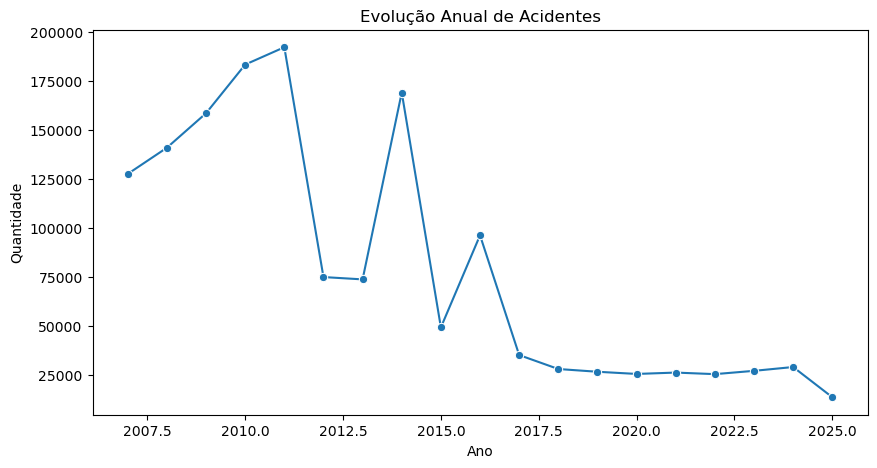

In [12]:
# Evolução ao longo dos anos (linha)
evolucao = tabela2007_2025.groupby('ano').size().reset_index(name='acidentes')
plt.figure(figsize=(10,5))
sns.lineplot(data=evolucao, x='ano', y='acidentes', marker='o')
plt.title('Evolução Anual de Acidentes')
plt.ylabel('Quantidade')
plt.xlabel('Ano')
plt.show()

## Evolução Anual de Acidentes

- Há uma tendência clara de crescimento no número de acidentes até aproximadamente 2011, seguida por uma queda acentuada e consistente nos anos seguintes.

- A partir de 2012 ocorre uma queda abrupta, que pode estar ligada a mudanças na base de registros da PRF ou leis mais rigorosas.

- Depois de 2017 a série se estabiliza em níveis muito menores.

- Mostra que houve um ponto de inflexão em torno de 2012-2013.
---

## Médias Móveis de 30 Dias Para Suavizar a curva:

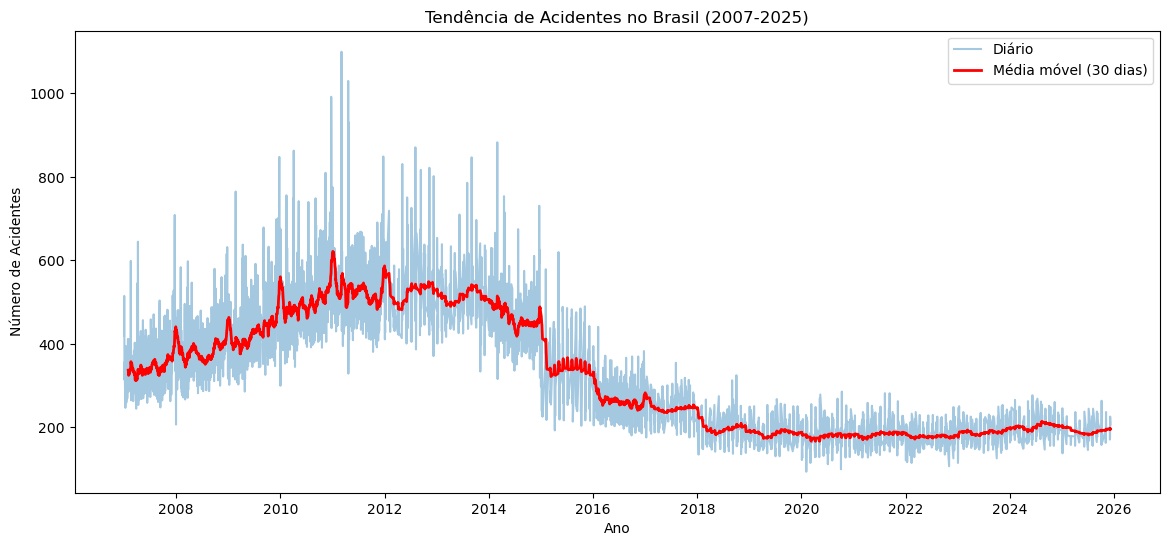

In [13]:
# Usando Medias Móveis de 30 dias

# Contagem de acidentes por dia
acidentes_por_dia = tabela2007_2025.groupby('data_inversa').size().reset_index(name='acidentes')

acidentes_por_dia['media_movel_30d'] = acidentes_por_dia['acidentes'].rolling(window=30).mean()


plt.figure(figsize=(14,6))
plt.plot(acidentes_por_dia['data_inversa'], acidentes_por_dia['acidentes'], alpha=0.4, label='Diário')
plt.plot(acidentes_por_dia['data_inversa'], acidentes_por_dia['media_movel_30d'], color='red', linewidth=2, label='Média móvel (30 dias)')
plt.title("Tendência de Acidentes no Brasil (2007-2025)")
plt.xlabel("Ano")
plt.ylabel("Número de Acidentes")
plt.legend()
plt.show()


## Médias móveis de 30 dias (Tendência diária)

- A suavização mostra que os acidentes seguiam em alta até 2012, depois caíram progressivamente.

- Após 2016 a média diária fica relativamente estável.
---

## Visualização da Data de Possiveis Marcos que Influenciam no Aumento ou Diminuição dos Acidentes

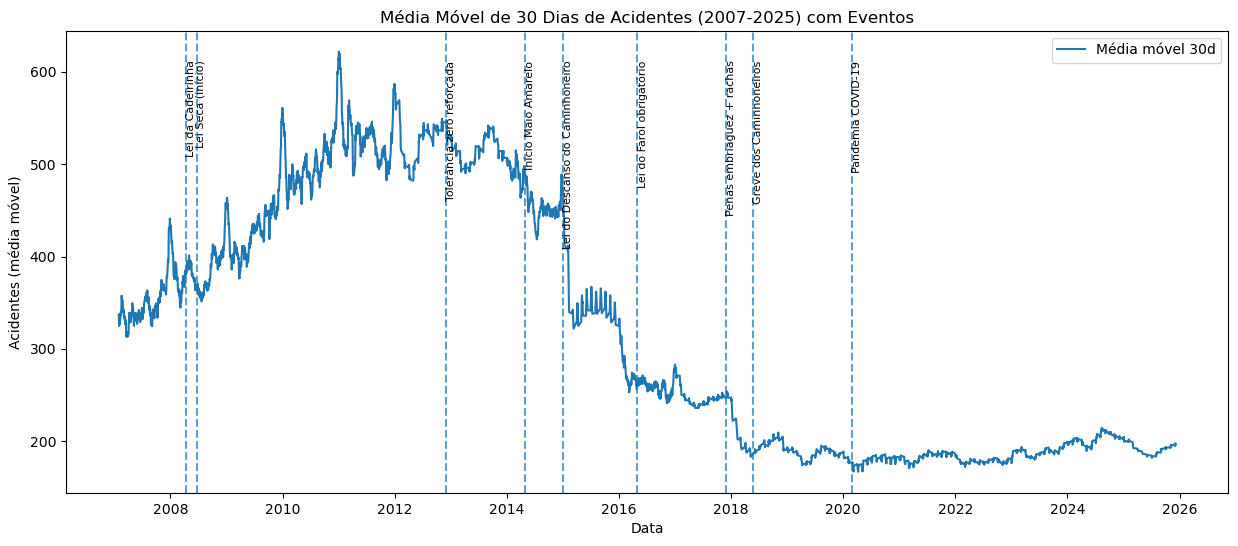

In [14]:
# Considerando marcos que podem ter influenciado o aumento ou diminuição dos acidentes

plt.figure(figsize=(15,6))
plt.plot(acidentes_por_dia['data_inversa'], acidentes_por_dia['media_movel_30d'], label='Média móvel 30d')

# Eventos:
eventos = {
    'Lei Seca (início)': '2008-06-20',
    'Tolerância zero reforçada': '2012-12-01',
    'Início Maio Amarelo': '2014-05-01',
    'Lei do Descanso do Caminhoneiro': '2015-01-01',
    'Lei do Farol obrigatório': '2016-05-01',
    'Penas embriaguez + rachas': '2017-12-01',
    'Greve dos Caminhoneiros': '2018-05-21',
    'Pandemia COVID-19': '2020-03-01',
    'Lei da Cadeirinha': '2008-04-12'
}

for nome, data_str in eventos.items():
    data = pd.to_datetime(data_str)
    plt.axvline(x=data, linestyle='--', alpha=0.7)
    plt.text(data, plt.ylim()[1]*0.95, nome, rotation=90, verticalalignment='top', fontsize=8)

plt.title("Média Móvel de 30 Dias de Acidentes (2007-2025) com Eventos")
plt.xlabel("Data")
plt.ylabel("Acidentes (média móvel)")
plt.legend()
plt.show()


## Eventos e Legislação (com anotações no gráfico)

- A "Lei Seca" (2008 e reforços em 2012) coincidem com o início da queda, mas a grande virada veio depois.

- "Lei do Descanso" e "Lei do Farol" (2015-2016): Coincidem com a aceleração da queda, sugerindo um impacto positivo de legislações focadas na segurança e condições dos motoristas.

- “Pandemia COVID-19” (2020) também mostra impacto visível com queda nos acidentes devido à redução de mobilidade.

- Indica que leis e fatores externos têm influência real no comportamento da curva.
---

**Conclusão da Pergunta 1:** A análise da série histórica revela uma tendência de crescimento no número de acidentes até o pico por volta de 2013, seguida por uma queda acentuada e consistente. Esta queda coincide fortemente com a implementação de legislações mais rigorosas, como a Lei nº 12.971/2014, e a Lei do Descanso em 2015. Eventos como a pandemia de COVID-19 também causaram quedas abruptas devido à redução da mobilidade.

#### **2. A severidade dos acidentes, medida pelo número de mortes, seguiu a mesma tendência de queda? É possível modelar essa redução ao longo do tempo?**

## Quantidade de Fatalidades com Regressão Linear

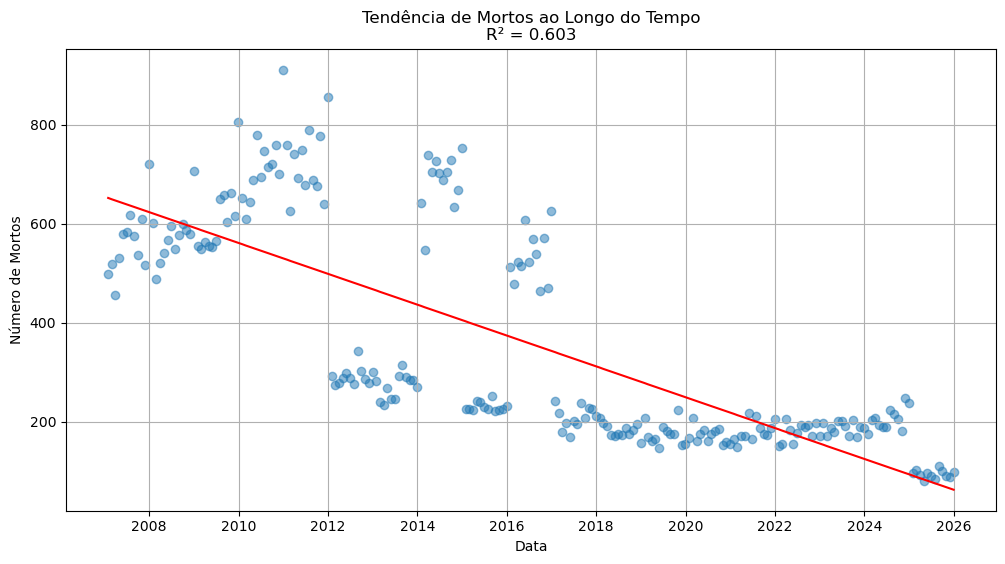

In [15]:
# Preparar dados para regressão
acidentes_mensais = tabela2007_2025.groupby(pd.Grouper(key='data_inversa', freq='M')).agg({
    'mortos': 'sum',
    'feridos_graves': 'sum',
    'feridos_leves': 'sum'
}).reset_index()

# Criar feature temporal numérica
acidentes_mensais['meses_desde_inicio'] = range(len(acidentes_mensais))

# Realizar regressão linear
X = acidentes_mensais[['meses_desde_inicio']]
y = acidentes_mensais['mortos']

modelo = LinearRegression()
modelo.fit(X, y)

# Plotar dados e linha de tendência
plt.figure(figsize=(12, 6))
plt.scatter(acidentes_mensais['data_inversa'], y, alpha=0.5)
plt.plot(acidentes_mensais['data_inversa'], modelo.predict(X), color='red')

plt.title(f'Tendência de Mortos ao Longo do Tempo\nR² = {modelo.score(X, y):.3f}')
plt.xlabel('Data')
plt.ylabel('Número de Mortos')
plt.grid(True)
plt.show()

**Conclusão da Pergunta 2:** Sim, a severidade dos acidentes também apresenta uma clara tendência de queda. O modelo de regressão linear aplicado aos dados mensais de mortes confirma essa observação, mostrando uma linha de tendência descendente e um coeficiente de determinação ($R^2$) de aproximadamente 0.603. Isso indica que cerca de 60% da variação no número de mortes ao longo do tempo pode ser explicada por essa tendência linear de redução.

#### **3. Quais são os padrões de risco de acidentes fatais considerando os meses do ano, estações do ano, feriados, dias da semana e os diferentes períodos do dia?**

## Agrupamento de Acidentes por Mês x Ano:

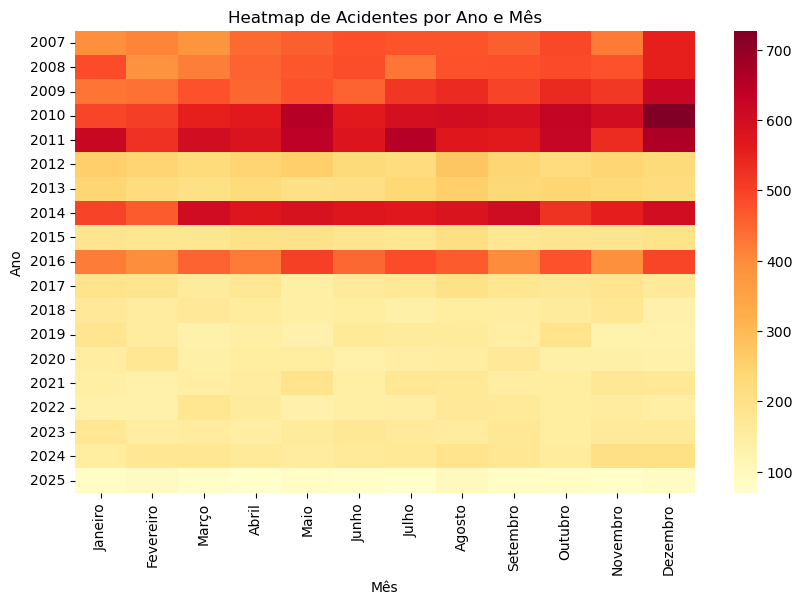

In [16]:
# Agrupando por ano e mês
acidentes_com_mortos = tabela2007_2025[tabela2007_2025['mortos'] > 0].groupby(["ano", "mes"]).size().reset_index(name="acidentes_com_mortos")

meses_ordem = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
acidentes_com_mortos['mes'] = pd.Categorical(acidentes_com_mortos['mes'], categories=meses_ordem, ordered=True)

# Pivot para formato de matriz
heatmap_data = acidentes_com_mortos.pivot(index="ano", columns="mes", values="acidentes_com_mortos")

# Plotar heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=False)
plt.title("Heatmap de Acidentes por Ano e Mês")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()


## Heatmap (Acidentes por Ano e Mês)

- Antes de 2012 há concentração muito alta de acidentes fatais, com destaque para julho e dezembro (meses de férias).

- Depois da queda de 2015, o padrão sazonal ainda existe, mas em menor escala.

- Mostra que férias são períodos críticos.
---

## Acientes em Feriaos ou Datas Normais

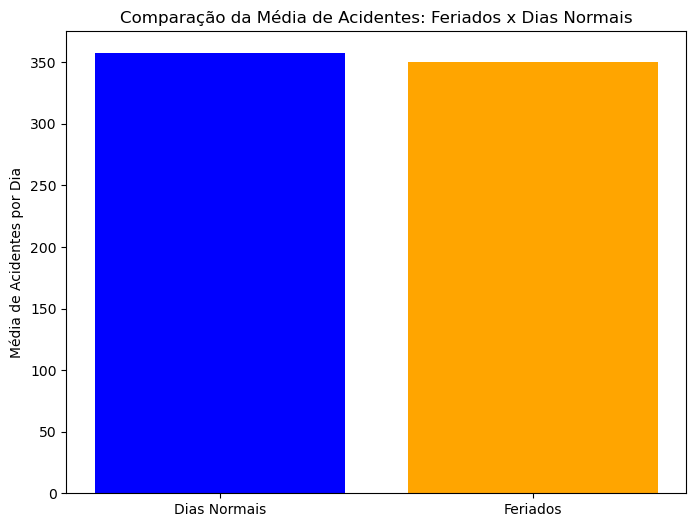

In [17]:
# Criar coluna auxiliar para contar dias únicos por grupo (feriado ou não)
dias_por_tipo = tabela2007_2025[tabela2007_2025["mortos"] > 0].groupby("feriado")["data_inversa"].nunique()

# Contar acidentes por tipo de dia
acidentes_por_tipo = tabela2007_2025.groupby("feriado")["data_inversa"].count()

# Calcular média de acidentes por dia
media_por_dia = acidentes_por_tipo / dias_por_tipo

# Transformar em DataFrame para facilitar o plot
resultado = media_por_dia.reset_index()
resultado.columns = ["Feriado", "Média de Acidentes por Dia"]

# Substituir True/False por rótulos mais claros
resultado["Feriado"] = resultado["Feriado"].map({True: "Feriados", False: "Dias Normais"})


# Plotar comparação
plt.figure(figsize=(8,6))
plt.bar(resultado["Feriado"], resultado["Média de Acidentes por Dia"], color=["blue","orange"])
plt.ylabel("Média de Acidentes por Dia")
plt.title("Comparação da Média de Acidentes: Feriados x Dias Normais")
plt.show()


## Acidentes em Feriados x Dias Normais

- A média similar entre dias normais e feriados pode ocorrer porque, embora o fluxo em algumas rodovias aumente, o tráfego de "commute" diário (ida e volta do trabalho) diminui drasticamente no país todo, resultando em uma média geral menor. Além disso, operações policiais são reforçadas em feriados.

- Porém, com o cálculo da média de acidentes por dia, analisamos que feriados tem uma taxa quase tão alta quanto em dias normais.

- Conclusão parcial: O fato as médias semelhantes mesmo com o tráfego reuzido, feriados concentram riscos significantes.
---

## Boxplot por Momento do Dia, Dia da Semana, Estação do Ano e Categoria do Dia (Dia Útil ou Final de Semana)

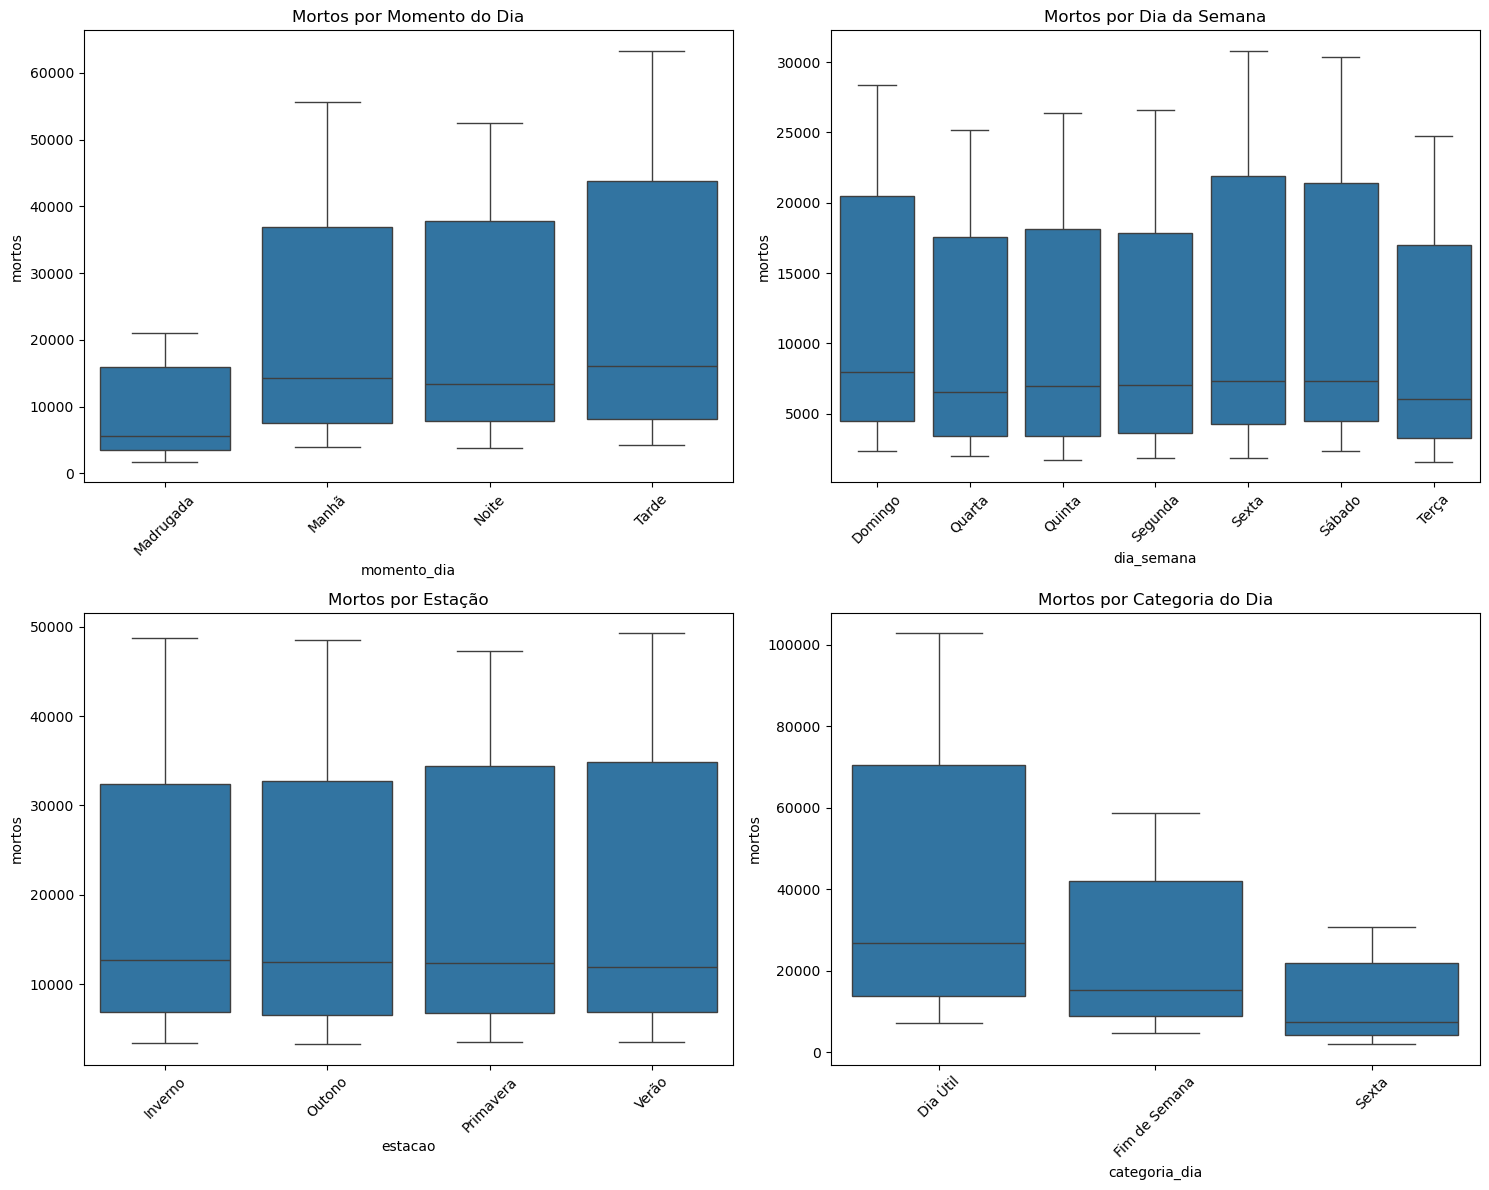

In [18]:
# Box plots para diferentes dimensões temporais
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Por hora do dia
tabela_momento_dia = tabela2007_2025.groupby(["ano", "momento_dia"]).size().reset_index(name="mortos")
sns.boxplot(data=tabela_momento_dia, x='momento_dia', y='mortos', ax=axes[0,0])
axes[0,0].set_title('Mortos por Momento do Dia')
axes[0,0].tick_params(axis='x', rotation=45)

# Por dia da semana
tabela_dia_semana = tabela2007_2025.groupby(["ano", "dia_semana"]).size().reset_index(name="mortos")
sns.boxplot(data=tabela_dia_semana, x='dia_semana', y='mortos', ax=axes[0,1])
axes[0,1].set_title('Mortos por Dia da Semana')
axes[0,1].tick_params(axis='x', rotation=45)

# Por estação do ano
tabela_estacao = tabela2007_2025.groupby(["ano", "estacao"]).size().reset_index(name="mortos")
sns.boxplot(data=tabela_estacao, x='estacao', y='mortos', ax=axes[1,0])
axes[1,0].set_title('Mortos por Estação')
axes[1,0].tick_params(axis='x', rotation=45)

# Por categoria do dia
tabela_categoria_dia = tabela2007_2025.groupby(["ano", "categoria_dia"]).size().reset_index(name="mortos")
sns.boxplot(data=tabela_categoria_dia, x='categoria_dia', y='mortos', ax=axes[1,1])
axes[1,1].set_title('Mortos por Categoria do Dia')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Boxplot por Estação do Ano

- Noite e Tarde são os períodos com maior mediana e dispersão de mortes.

- Fins de semana (Sexta, Sábado, Domingo) são claramente mais letais que os dias úteis. Sábado se destaca.

- Não há uma diferença muito significativa na mortalidade entre as estações do ano; as medianas são muito próximas.

- Com isso a gente conclui que condições de tráfego e calendário social pesam mais do que clima em si.

- O gráfico de categoria o dia confirma o achado anterior: Fins de semana são significativamente mais perigosos em termos de fatalidades.

### **Conclusão da Pergunta 3:** A análise revela padrões de risco bem definidos. Os fins de semana, especialmente **sábado e domingo**, apresentam uma mediana e uma dispersão de mortes por acidente significativamente maiores em comparação com os dias úteis. Em relação ao período, a **noite** se destaca como o momento do dia com os acidentes mais fatais, seguido pela tarde.

# Análise Breve de Ocorrência de Acidentes

## Dias Momento do Dia x Categoria do Dia:

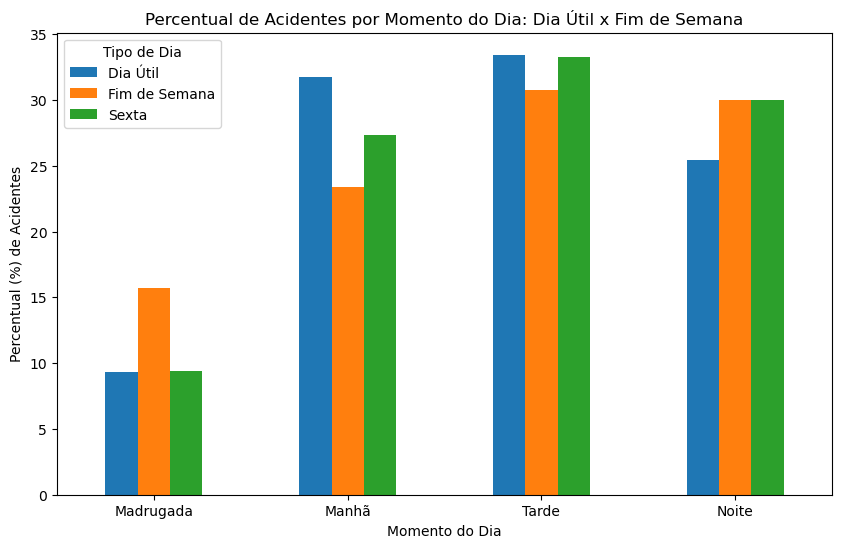

In [19]:
# Contagem de acidentes agrupada
comparacao = (
    tabela2007_2025.groupby(['categoria_dia','momento_dia'])
    .size()
    .reset_index(name='acidentes')
)

# Calcular percentual dentro de cada categoria_dia
comparacao['percentual'] = (
    comparacao.groupby('categoria_dia')['acidentes']
    .transform(lambda x: 100 * x / x.sum())
)

# Ordenar momentos do dia para exibir na ordem certa
ordem = ["Madrugada", "Manhã", "Tarde", "Noite"]
comparacao['momento_dia'] = pd.Categorical(comparacao['momento_dia'], categories=ordem, ordered=True)

# Pivotar para gráfico
comparacao_pivot = comparacao.pivot(index='momento_dia', columns='categoria_dia', values='percentual')

# Gráfico de barras lado a lado
comparacao_pivot.plot(kind='bar', figsize=(10,6))
plt.title("Percentual de Acidentes por Momento do Dia: Dia Útil x Fim de Semana")
plt.xlabel("Momento do Dia")
plt.ylabel("Percentual (%) de Acidentes")
plt.xticks(rotation=0)
plt.legend(title="Tipo de Dia")
plt.show()


## Percentual por Momento do Dia (Categorias de Dia)

- Em dias úteis, picos claros na manhã e na tarde, consistentes com horários de pico e deslocamento para o trabalho.

- Nos finais e semana, o padrão muda. A madrugada e a noite ganham muito mais relevância percentual, sugerindo acidentes ligados a atividades de lazer e possível consumo de álcool.

- E a Sexta-Feira funciona como um dia de transição, com um padrão que mistura características de dia útil (pico à tarde) e de fim de semana (noite com alta representatividade).

## Distribuição de Acidentes nas Sextas e Sábados por Momento do Dia

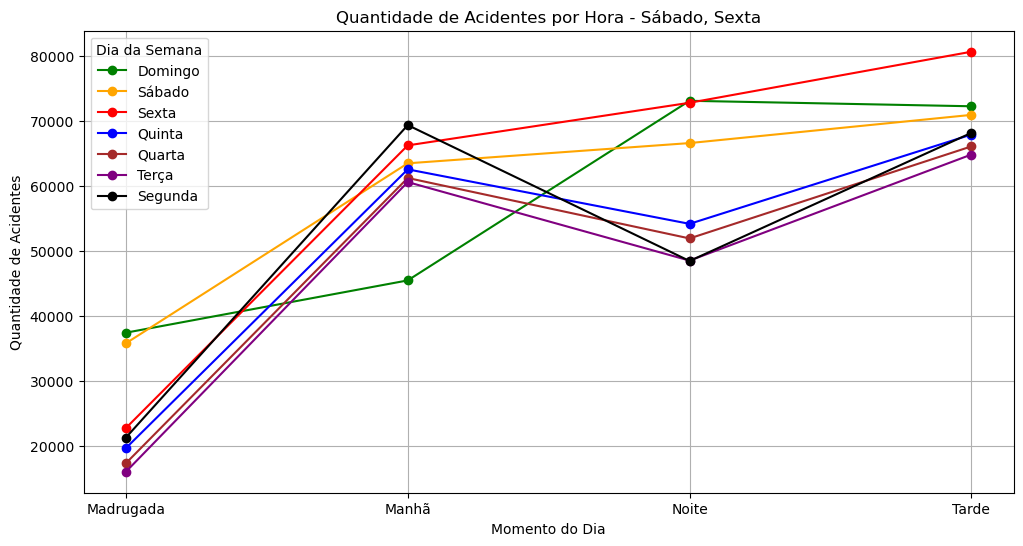

In [20]:
filtro_fim_de_semana = tabela2007_2025['dia_semana'].isin(['Sábado', 'Sexta', 'Quinta', 'Domingo', 'Segunda', 'Terça', 'Quarta'])

dados_fds = tabela2007_2025[filtro_fim_de_semana]

agrupado = dados_fds.groupby(['momento_dia', 'dia_semana']).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
plt.plot(agrupado.index, agrupado['Domingo'], marker='o', label='Domingo', color='green')
plt.plot(agrupado.index, agrupado['Sábado'], marker='o', label='Sábado', color='orange')
plt.plot(agrupado.index, agrupado['Sexta'], marker='o', label='Sexta', color='red')
plt.plot(agrupado.index, agrupado['Quinta'], marker='o', label='Quinta', color='blue')
plt.plot(agrupado.index, agrupado['Quarta'], marker='o', label='Quarta', color='brown')
plt.plot(agrupado.index, agrupado['Terça'], marker='o', label='Terça', color='purple')
plt.plot(agrupado.index, agrupado['Segunda'], marker='o', label='Segunda', color='black')

plt.title('Quantidade de Acidentes por Hora - Sábado, Sexta')
plt.xlabel('Momento do Dia')
plt.ylabel('Quantidade de Acidentes')
plt.legend(title='Dia da Semana')
plt.grid(True)
plt.show()

## Sexta x Sábado por Momento do Dia

- Sexta tem mais acidentes noturnos/tarde que sábado.

- Sábado tem mais acidentes de madrugada (provavelmente de sexta para sábado). Isso sugere que a madrugada de sábado concentra riscos possivelmente ligados a festas/baladas e o início da noite de sexta já mostra perigo elevado.

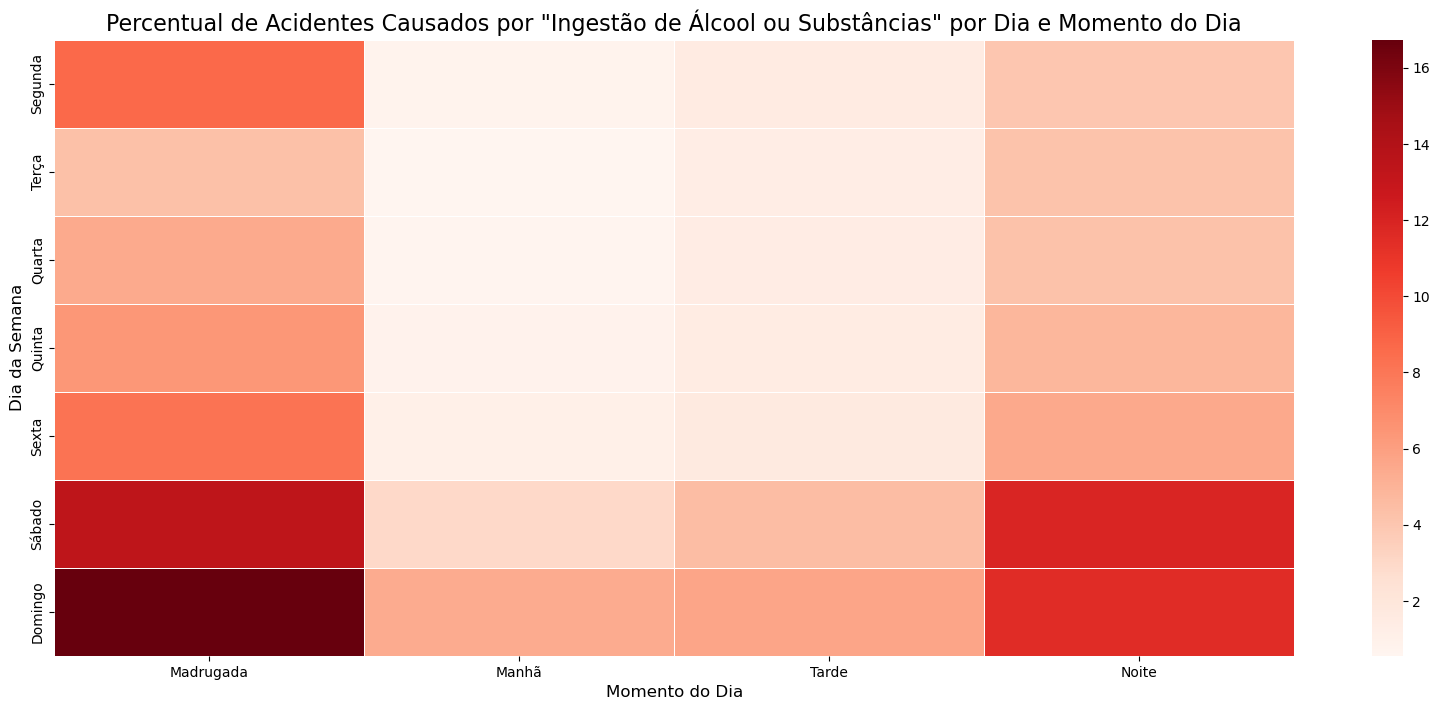

In [21]:
# TOTAL de acidentes para cada dia e momento do dia
total_acidentes = tabela2007_2025.groupby(['dia_semana', 'momento_dia']).size().reset_index(name='total')

# Acidentes por ÁLCOOL para cada dia e momento do dia
filtro_alcool = tabela2007_2025['causa_acidente'] == 'Ingestão de Álcool ou Substâncias'
acidentes_alcool = tabela2007_2025[filtro_alcool].groupby(['dia_semana', 'momento_dia']).size().reset_index(name='alcool')

# Juntar as duas contagens em uma única tabela
analise_alcool = pd.merge(total_acidentes, acidentes_alcool, on=['dia_semana', 'momento_dia'], how='left')

# Preencher com 0 os horários onde não houve acidentes por álcool
analise_alcool['alcool'] = analise_alcool['alcool'].fillna(0)

# Calcular o PERCENTUAL de acidentes por álcool
analise_alcool['percentual_alcool'] = (analise_alcool['alcool'] / analise_alcool['total']) * 100

# Preparar a tabela pivô para o heatmap
# Ordenar os dias da semana corretamente (com o novo formato dos nomes)
dias_ordem = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
momentos_ordem = ['Madrugada', 'Manhã', 'Tarde', 'Noite']
analise_alcool['dia_semana'] = pd.Categorical(analise_alcool['dia_semana'], categories=dias_ordem, ordered=True)
analise_alcool['momento_dia'] = pd.Categorical(analise_alcool['momento_dia'], categories=momentos_ordem, ordered=True)

heatmap_data = analise_alcool.pivot_table(index='dia_semana', columns='momento_dia', values='percentual_alcool')

# 7. Gerar o heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(heatmap_data, cmap="Reds", annot=False, linewidths=.5)

plt.title('Percentual de Acidentes Causados por "Ingestão de Álcool ou Substâncias" por Dia e Momento do Dia', fontsize=16)
plt.xlabel('Momento do Dia', fontsize=12)
plt.ylabel('Dia da Semana', fontsize=12)
plt.show()

#### **4. Quais as principais causas e tipos de acidentes e como eles se relacionam com a letalidade?**

C:\Users\henri\AppData\Local\Temp\ipykernel_47044\2053500198.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='taxa_letalidade', y='tipo_acidente', data=letalidade_tipo, palette='Reds_r')


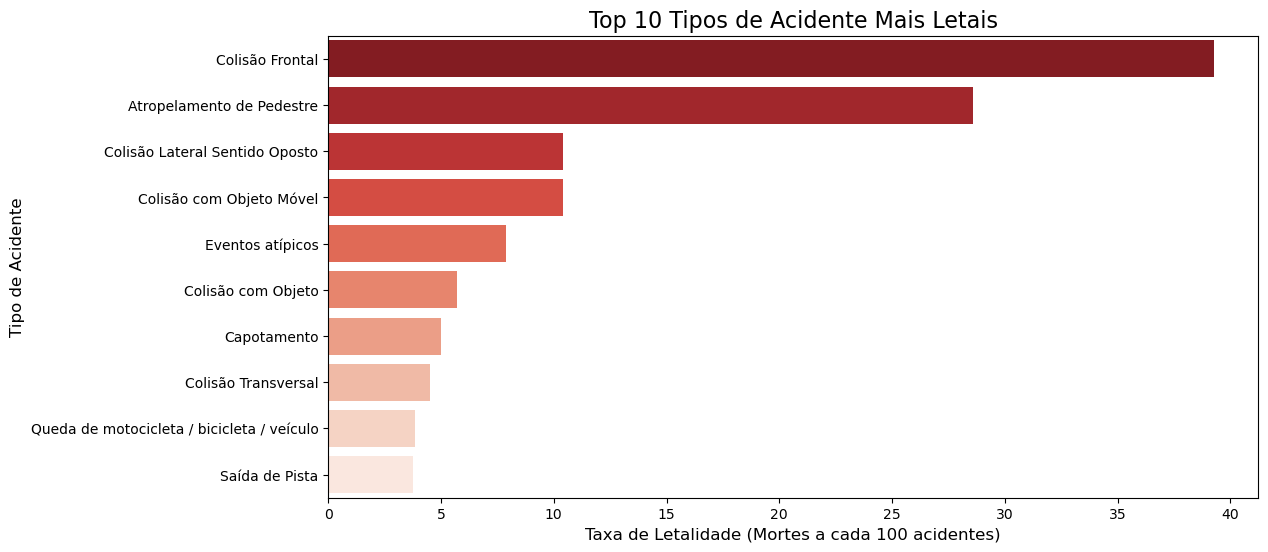

Tipos mais comuns:
tipo_acidente
Colisão Traseira                              394559
Saída de Pista                                227675
Colisão Lateral                               219626
Colisão Transversal                           155939
Colisão com Objeto Fixo                        85871
Tombamento                                     70911
Capotamento                                    70319
Colisão Frontal                                62787
Atropelamento de Pedestre                      47454
Queda de motocicleta / bicicleta / veículo     42025
Name: count, dtype: int64


In [22]:
# Top 10 tipos de acidente mais comuns
top_10_tipos = tabela2007_2025['tipo_acidente'].value_counts().nlargest(10)

# Top 10 causas de acidente mais comuns
top_10_causas = tabela2007_2025['causa_acidente'].value_counts().nlargest(10)

# Cálculo da taxa de letalidade por tipo de acidente
letalidade_tipo = tabela2007_2025.groupby('tipo_acidente').agg(total_acidentes=('tipo_acidente', 'count'), total_mortos=('mortos', 'sum')).reset_index()
letalidade_tipo['taxa_letalidade'] = (letalidade_tipo['total_mortos'] / letalidade_tipo['total_acidentes']) * 100
letalidade_tipo = letalidade_tipo.sort_values('taxa_letalidade', ascending=False).nlargest(10, 'taxa_letalidade')

# Gráfico dos tipos mais letais
plt.figure(figsize=(12, 6))
sns.barplot(x='taxa_letalidade', y='tipo_acidente', data=letalidade_tipo, palette='Reds_r')
plt.title('Top 10 Tipos de Acidente Mais Letais', fontsize=16)
plt.xlabel('Taxa de Letalidade (Mortes a cada 100 acidentes)', fontsize=12)
plt.ylabel('Tipo de Acidente', fontsize=12)
plt.show()

print("Tipos mais comuns:")
print(top_10_tipos)

#### **5. Com base na média de mortes, é possível agrupar as horas do dia em diferentes perfis de risco?**

c:\Users\henri\miniconda3\envs\mpdl\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\henri\miniconda3\envs\mpdl\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


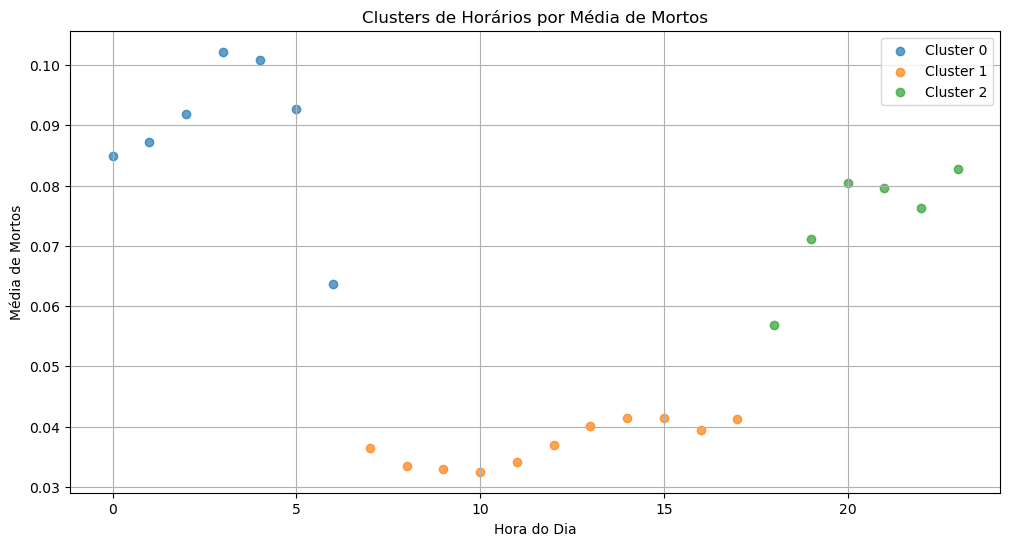

In [23]:
# Preparar dados para clustering
features_clustering = tabela2007_2025.groupby(['hora']).agg({
    'mortos': 'mean',
    'feridos_graves': 'mean',
    'feridos_leves': 'mean'
}).reset_index()

# Normalizar todas as features, incluindo a hora
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_clustering)

# Aplicar K-means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar clusters ao DataFrame
features_clustering['cluster'] = clusters

# Plotar resultados
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    cluster_data = features_clustering[features_clustering['cluster'] == i]
    plt.scatter(cluster_data['hora'], cluster_data['mortos'], 
                label=f'Cluster {i}', alpha=0.7)

plt.title('Clusters de Horários por Média de Mortos')
plt.xlabel('Hora do Dia')
plt.ylabel('Média de Mortos')
plt.legend()
plt.grid(True)
plt.show()

# Análise de Acidentes em João Pessoa

#### **Objetivos**

Utilizando o dataset RENAEST (Registro Nacional de Acidentes e Estatísticas de Trânsito) filtrado apenas para dados referentes a cidade de João pessoa, que compila informações sobre acidentes em âmbito nacional e possui dados específicos de rodovias estaduais,municipais e federais, analisaremos os acidentes ocorridos em João Pessoa entre 2018 a 2025, com o objetivo de fornecer uma visão geral sobre como e onde esses acidentes ocorreram.


1. **Quais os bairro que mais registraram acidentes ?**

2.  **Qual o Padrao de vitimas que mais sofrem acidentes na cidade de João pessoa ?** 



## Carregar dados Filtrados apenas para João Pessoa e normalizar colunas

In [ ]:
import gdown
import pandas as pd


url = "https://drive.google.com/uc?id=1Gzjw9H7zt6OYMDm_yrh88AJjU0Fls4QQ"
output = "acidentes_jp_pb.csv"
gdown.download(url, output, quiet=False)


df_jp = pd.read_csv(output, sep=",", low_memory=False)

# Converter datas
df_jp["data_acidente"] = pd.to_datetime(df_jp["data_acidente"], errors="coerce")
df_jp["ano_mes"] = df_jp["data_acidente"].dt.to_period("M")

# Normalizar hora dos acidentes
# string de 6 dígitos
df_jp["hora_acidente_str"] = df_jp["hora_acidente"].astype(str).str.zfill(6)



def limpar_categoria(df, coluna):
    "Remove linhas com categorias 'NÃO INFORMADO' ou 'DESCONHECIDO'"
    return df[~df[coluna].str.upper().isin(["NAO INFORMADO", "NÃO INFORMADO", "DESCONHECIDO"])]


Downloading...
From: https://drive.google.com/uc?id=1Gzjw9H7zt6OYMDm_yrh88AJjU0Fls4QQ
To: c:\Users\alexa\OneDrive\Área de Trabalho\Projeto ICD\acidentes_jp_pb.csv
100%|██████████| 2.99M/2.99M [00:00<00:00, 6.17MB/s]


# Evolução Anual do acidentes em JP e Frequencia diaria

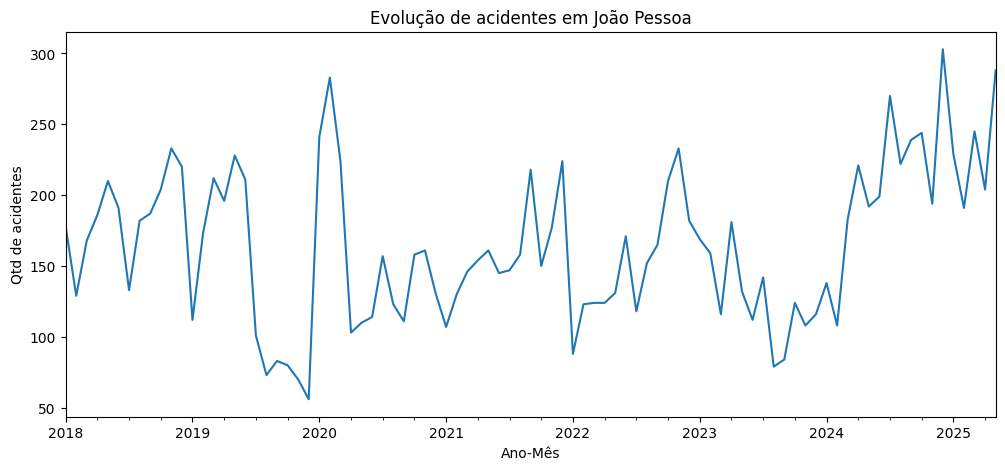

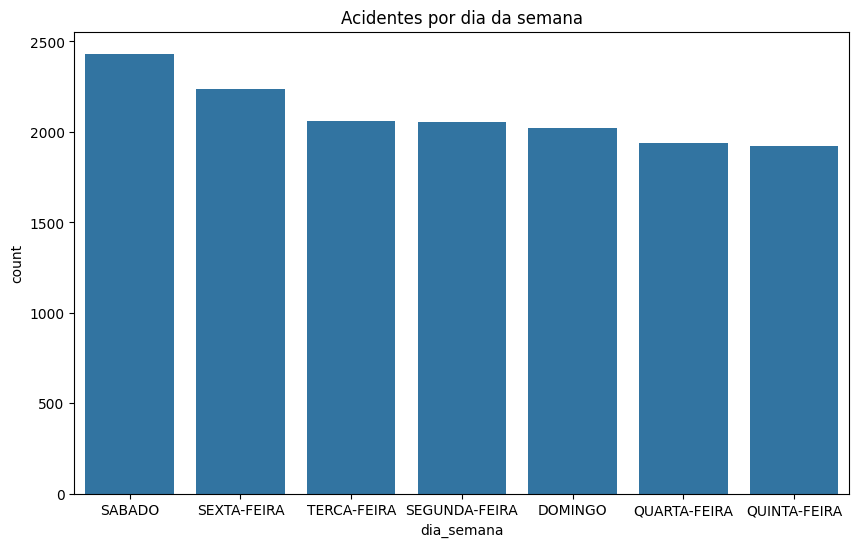

C:\Users\alexa\AppData\Local\Temp\ipykernel_22356\2913009019.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_jp, x="fase_dia", order=df_fase_dia["fase_dia"].value_counts().index, palette="viridis")


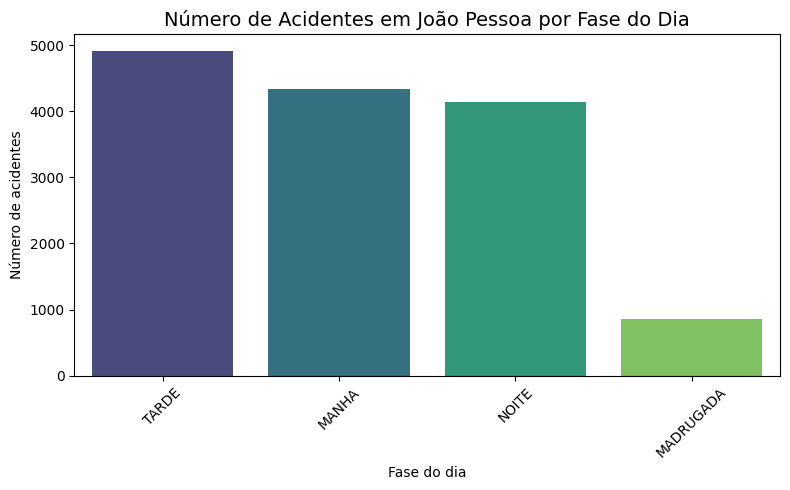

In [12]:
# Evolução mensal de acidentes
plt.figure(figsize=(12,5))
df_jp.groupby("ano_mes").size().plot()
plt.title("Evolução de acidentes em João Pessoa")
plt.ylabel("Qtd de acidentes")
plt.xlabel("Ano-Mês")
plt.show()

df_semana = limpar_categoria(df_jp, "dia_semana")
plt.figure(figsize=(10,6))
sns.countplot(data=df_semana, x="dia_semana", order=df_semana["dia_semana"].value_counts().index)
plt.title("Acidentes por dia da semana")
plt.show()

# Histograma de acidentes por hora
df_fase_dia = limpar_categoria(df_jp, "fase_dia")
plt.figure(figsize=(8,5))
sns.countplot(data=df_jp, x="fase_dia", order=df_fase_dia["fase_dia"].value_counts().index, palette="viridis")

plt.title("Número de Acidentes em João Pessoa por Fase do Dia", fontsize=14)
plt.xlabel("Fase do dia")
plt.ylabel("Número de acidentes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



- Observa-se que os acidentes em João Pessoa acompanham a tendência nacional, concentrando-se com maior frequência entre sexta-feira e sábado, nos meses de férias e, principalmente, nos turnos da manhã e da tarde.

# Observando onde mais ocorrem acidentes (bairro e ruas)

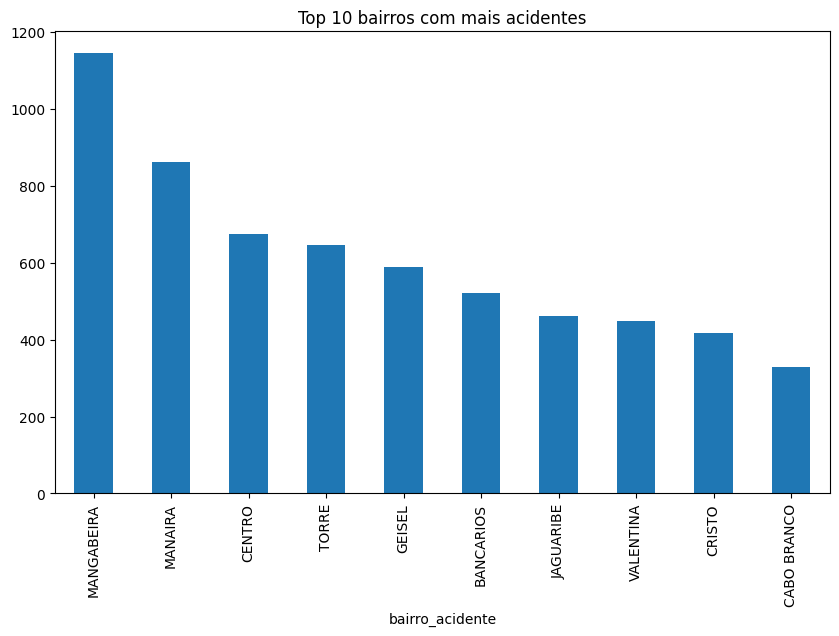

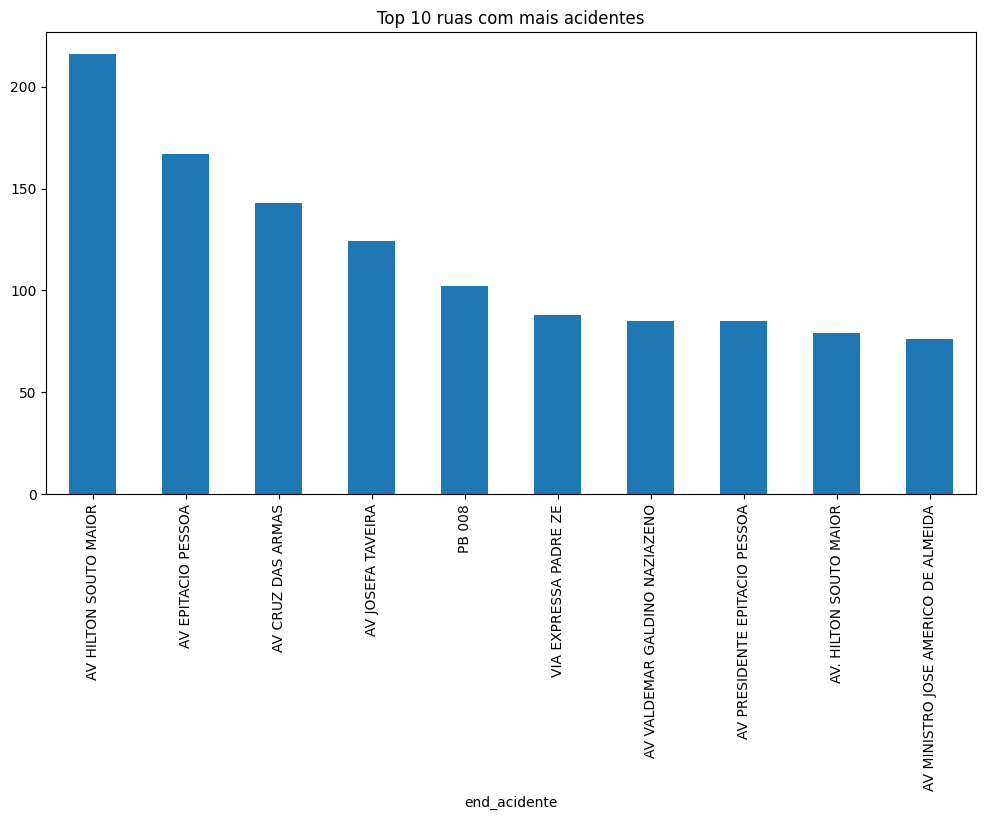

In [13]:
# Bairros críticos (sem NAO INFORMADO)
df_bairro = limpar_categoria(df_jp, "bairro_acidente")
plt.figure(figsize=(10,6))
df_bairro["bairro_acidente"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 bairros com mais acidentes")
plt.show()

# Ruas críticas (sem NAO INFORMADO)
df_rua = limpar_categoria(df_jp, "end_acidente")
plt.figure(figsize=(12,6))
df_rua["end_acidente"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 ruas com mais acidentes")
plt.show()

# Mangabeira e Manaíra apresentam o maior número de acidentes, mas também estão entre os bairros mais populosos de João Pessoa.

- A avenida Hilton Souto Maior é uma importante via da cidade, atualmente em processo de requalificação e alargamento. 

- Seria interessante comparar a frequência de acidentes antes e após a conclusão das obras, mas até o momento as obras ainda não foram finalizadas completamente.


# Qual a faixa etária que mais sofre acidentes de trânsito ? e tipo de veiculo mais perigoso ? 

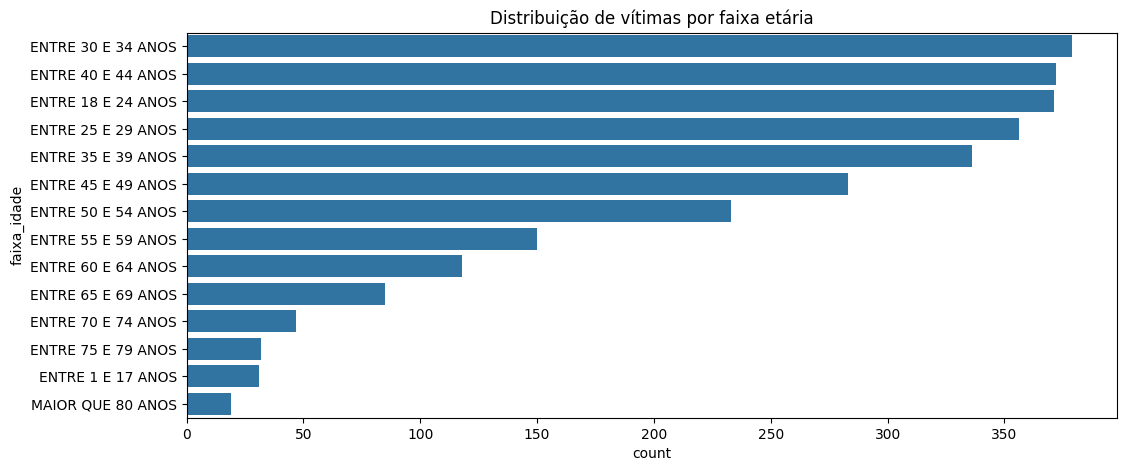

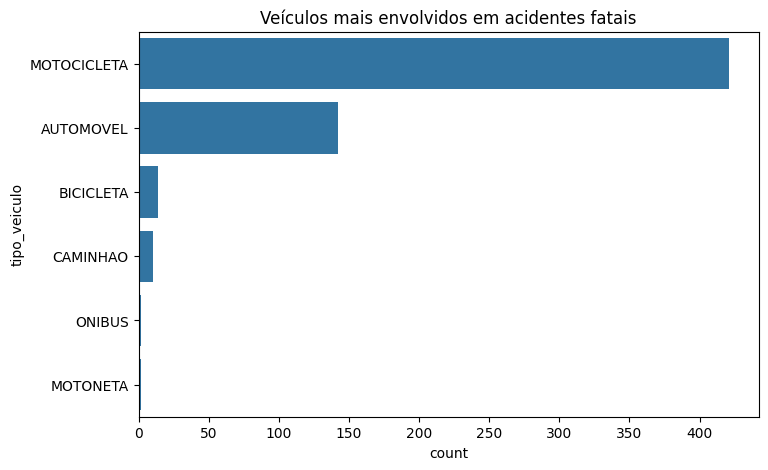

In [14]:
# Distribuição por faixa etária (sem NAO INFORMADO)
df_faixa = limpar_categoria(df_jp, "faixa_idade")
plt.figure(figsize=(12,5))
sns.countplot(
    data=df_faixa,
    y="faixa_idade",
    order=df_faixa["faixa_idade"].value_counts().index
)
plt.title("Distribuição de vítimas por faixa etária")
plt.show()

# Tipo de veículo em acidentes fatais (sem NAO INFORMADO)
fatal = df_jp[df_jp["qtde_acid_com_obitos"] > 0]
fatal = limpar_categoria(fatal, "tipo_veiculo")
plt.figure(figsize=(8,5))
sns.countplot(data=fatal, y="tipo_veiculo", order=fatal["tipo_veiculo"].value_counts().index)
plt.title("Veículos mais envolvidos em acidentes fatais")
plt.show()

# Qual é o perfil das vítimas mais propensas a sofrer acidentes em João Pessoa, considerando faixa etária, gênero, tipo de veículo e fase do dia em que conduzem os veículos ?

- Utiliando agrupamento e considerando 3 cluters 

Total de registros após limpeza: 2474

===== Perfil típico por cluster =====
                faixa_idade     genero tipo_veiculo fase_dia
cluster                                                     
0        ENTRE 30 E 34 ANOS  MASCULINO    AUTOMOVEL    NOITE
1        ENTRE 30 E 34 ANOS  MASCULINO  MOTOCICLETA    MANHA
2        ENTRE 30 E 34 ANOS  MASCULINO  MOTOCICLETA    TARDE

===== Quantidade de motoristas em cada cluster =====
cluster
1    905
2    852
0    717
Name: count, dtype: int64


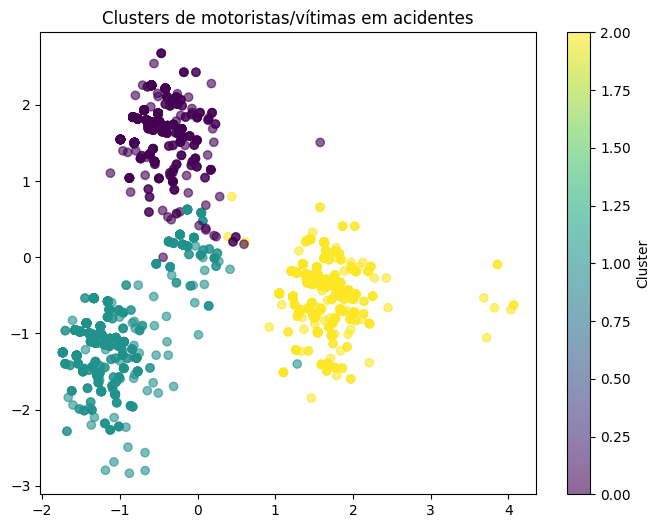

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Colunas 
cols_cluster = ["faixa_idade", "genero", "tipo_veiculo", "fase_dia"]

df_cluster = df_jp[cols_cluster].copy()

# Substituir valores nulos
df_cluster = df_cluster.fillna("NA")

# Remover valores não informados
for c in df_cluster.columns:
    df_cluster = df_cluster[
        ~df_cluster[c].astype(str).str.upper().isin(["NAO INFORMADO", "NÃO INFORMADO", "DESCONHECIDO"])
    ]

print("Total de registros após limpeza:", len(df_cluster))

if len(df_cluster) > 0:
    df_encoded = pd.get_dummies(df_cluster, drop_first=True)

    scaler = StandardScaler()
    X = scaler.fit_transform(df_encoded)


    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_cluster["cluster"] = kmeans.fit_predict(X)

    # Perfil típico de cada cluster
    perfil = df_cluster.groupby("cluster").agg(lambda x: x.value_counts().index[0])
    print("\n===== Perfil típico por cluster =====")
    print(perfil)

    print("\n===== Quantidade de motoristas em cada cluster =====")
    print(df_cluster["cluster"].value_counts())

    # Visualização PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=df_cluster["cluster"], cmap="viridis", alpha=0.6)
    plt.title("Clusters de motoristas/vítimas em acidentes")
    plt.colorbar(label="Cluster")
    plt.show()




## Primeira Conclusão Final

- Tendência Geral: O Brasil vivenciou uma queda expressiva e sustentada no número de acidentes e mortes em rodovias federais desde 2014.

- Fatores de Impacto: Legislações mais rígidas, fiscalização e eventos de grande escala (como a pandemia) demonstraram ter um impacto direto e mensurável na segurança viária.

- Padrões de Risco: Fins de semana, especialmente no período da noite, são consistentemente os mais perigosos e letais. Os horários entre 18h e 23h foram identificados como o cluster de maior risco de fatalidade.

- 

Uma possível medida para previnir tais ocorrências é a fiscalização rodoviária aos finais de semanas, principalmente na sexta-feira

---